# Econ 1923 - Product Differentiation Project

## 1 Preparation
### 1.1 Obtaining the data
Create a data set containing nutrition information about cereal boxes. You can use all sources including the nutrition APIs, stores web pages, actual grocery stores, your pantry, etc.
At the end of this process, you should have a dataframe that contains as many cereal boxes as possible and for each, you should have several nutritional facts and (ideally) serving sizes (cups or grams).
The result of this part can be several dataframes, each resulting from the different data sources that you used.

Sources: Edemam API, GitHub JSON Files, personal cereals


In [2]:
#Importing packages
import requests, json, time
import pandas as pd
from matplotlib import pyplot as plt
%run ../APIkeys.py

In [3]:
app_id = os.environ['EDAMAM_API_id']
key = os.environ['EDAMAM_API_key']
baseURL = 'https://api.edamam.com/api/food-database/v2/parser?app_id='+app_id+'&app_key='+key+'&upc='
endURL = '&nutrition-type=cooking&category=packaged-foods'

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [4]:
def checkUPC_V2(upc):
    app_id = os.environ['EDAMAM_API_id']
    key = os.environ['EDAMAM_API_key']
    baseURL = 'https://api.edamam.com/api/food-database/v2/parser?app_id='+app_id+'&app_key='+key+'&upc='
    endURL = '&nutrition-type=cooking&category=packaged-foods'
    url = baseURL + upc + endURL
    info = requests.get(url).json()
    if 'error' in info:
        return info
    else:
        answer = info['hints'][0]['food']['nutrients']
        
        sizeList = info['hints'][0]['food']['servingSizes']
        n = len(sizeList)
        for i in range(n):
            if sizeList[i]['label'] == 'Gram':
                answer['servingSize_gram'] = info['hints'][0]['food']['servingSizes'][i]['quantity']
            if sizeList[i]['label'] == 'Cup':
                answer['servingSize_cup'] = info['hints'][0]['food']['servingSizes'][i]['quantity']
        
        answer['label'] = info['hints'][0]['food']['label']
        return answer

In [5]:
#We add a 3 second interval between each call to stay under the limit for the Edamam API.

def multiUPC(shelf):
    a = []
    missing = []
    for upc in shelf:
        info = checkUPC_V2(upc)
        if 'error' in info:
            print('UPC ',upc, ' does not exist in the API\'s data base')
            missing.append(upc)
            time.sleep(3)
        else:
            print('UPC ',upc, ' exists in the API\'s data base')
            a.append(info)
            time.sleep(3)
    return a

In [6]:
#reading excel and csv files containing states' WIC 
#Approved Products Lists (APLs) and filtering down to cereal UPCs

df_IL = pd.read_excel('IL_WIC_APL.xlsx') #Illinois
df_IL = df_IL.drop([174], axis=0)
df_IL = df_IL.reset_index(drop=True)

df_MA = pd.read_excel('MA_WIC_APL.xlsx')
df_MA = df_MA[df_MA['Category Name']=='Breakfast Cereal'] #Massachusetts
df_MA = df_MA.reset_index(drop=True)

df_MN = pd.read_excel('MN_WIC_APL.xlsx')#Minnesota

df_NE = pd.read_excel('NE_WIC_APL.xlsx')#Nebraska

df_NV = pd.read_csv('NV_WIC_APL.csv')#Nevada

df_NY = pd.read_excel('NY_WIC_APL.xlsx')#New York S
df_NY = df_NY[df_NY['Category']=='Breakfast Cereal ']
df_NY = df_NY.reset_index(drop=True)

In [7]:
#Isolating UPCs into string arrays and combining
IL_UPCs = []
for i in range(0,len(df_IL['UPC/PLU Code'])-1):
    IL_UPCs.append(df_IL['UPC/PLU Code'][i][7:18])
    
MA_UPCs = []
for i in range(0,len(df_MA['UPC'])-1):
    MA_UPCs.append(str(df_MA['UPC'][i]))

MN_UPCs = []
for i in range(0,len(df_MN['UPC_PLU'])-1):
    MN_UPCs.append(str(df_MN['UPC_PLU'][i]))
    
NE_UPCs = []
for i in range(0,len(df_NE['UPC'])-1):
    NE_UPCs.append(str(df_NE['UPC'][i]))

NV_UPCs = []
for i in range(0,len(df_NV['UPC'])-1):
    if len(df_NV['UPC'][i])==14:
        NV_UPCs.append(df_NV['UPC'][i][2:13])
    elif len(df_NV['UPC'][i])==15:
        NV_UPCs.append(df_NV['UPC'][i][3:14])

NY_UPCs = []
for i in range(0,len(df_NY['UPC/PLU Number'])-1):
    if len(str(df_NY['UPC/PLU Number'][i]))==11:
        NY_UPCs.append(str(df_NY['UPC/PLU Number'][i]))
    elif len(str(df_NY['UPC/PLU Number'][i]))==12:
        NY_UPCs.append(str(df_NY['UPC/PLU Number'][i])[1:12])
        
UPCs = IL_UPCs + MA_UPCs + MN_UPCs + NE_UPCs + NV_UPCs + NY_UPCs #combining
UPCs = list(set(UPCs)) #removes duplicate UPCs, and then coerces into a list

In [7]:
boxes, missing = multiUPC(UPCs)

####### This is is for if the above function doesn't work, for some reason it is buggy when running large batches, but running it manually without the funtion works for some reason

####### Change this block to Code to run

boxes = []
missing = []
for upc in UPCs:
    info = checkUPC_V2(upc)
    if 'error' in info:
        print('UPC ',upc, ' does not exist in the API\'s data base')
        missing.append(upc)
        time.sleep(3)
    else:
        print('UPC ',upc, ' exists in the API\'s data base')
        boxes.append(info)
        time.sleep(3)

In [10]:
Cereals = pd.DataFrame(boxes)

In [92]:
#The dataframe appears to still have some duplicate cereal labels, so we're dropping them
Cereals = Cereals.drop_duplicates(subset=['label'],keep='last')

#Add source column and fill with 
Cereals['Source'] = 'EDAMAM_API'

#Since calling all the UPCs takes a long time, we're saving the 
#dataframe into an excel sheet for quicker loader later on
Cereals.to_excel("Cereals.xlsx", sheet_name='Cereal Data')

In [8]:
Cereals = pd.read_excel('Cereals.xlsx')
len(Cereals['label'])

#Cereals

535

### 1.2 Cleaning and re-scaling
Various data sources may contain different variable names, different units, or different serving sizes. Also, missing values can be an issue. Here, you are asked to:
- Make sure that variable names in all dataframes that you created match.
- Make sure that all nutritional measurements in all data frames are the same (e.g. per cup or per 100gr).
- Merge the different data sources.
 
The final data set should include a column indicating the source of the observation (i.e. is it from the API, entered manually from a certain store, etc.).

### 1.3 Descriptive statistics
Create a table with descriptive statistics (Mean, Median, standard deviation, range, number of missing observations, etc.

In [33]:
# rename columns
Cereals = Cereals.rename(columns={"ENERC_KCAL": "CALORIES", "CHOCDF": "CARB", "PROCNT": "PROTEIN", "FE": "IRON", "CA": "CALCIUM", "FIBTG": "FIBER"})


In [34]:
Cereals.describe()

,Unnamed: 0,CALORIES,FAT,FASAT,FATRN,CARB,FIBER,SUGAR,PROTEIN,CHOLE,NA,CALCIUM,K,IRON,ZN,VITC,THIA,RIBF,NIA,VITB6A,FOLAC,VITB12,VITD,servingSize_cup,servingSize_gram,SUGAR.added,P,MG,FAMS,FAPU,TOCPHA,VITK1,Sugar.alcohol,WATER
count,535.000000,535.000000,532.000000,518.000000,523.0,535.000000,534.000000,529.000000,535.000000,512.000000,534.000000,419.000000,502.000000,472.000000,372.000000,348.000000,442.000000,404.000000,431.000000,413.000000,216.000000,336.000000,128.000000,416.000000,499.000000,90.000000,342.000000,296.000000,320.000000,323.000000,18.000000,6.0,7.0,1.0
mean,359.953271,361.111433,2.763904,0.084336,0.0,79.024305,7.697611,11.297532,9.071024,0.066291,429.136572,174.980678,309.825965,27.908296,9.882685,27.993291,1.221552,1.353977,15.593464,1.687441,1308.658918,5.642068,3.504019,0.923869,38.747883,16.353333,278.018533,87.379310,0.842283,0.917843,32.292371,0.0,0.0,4.8
std,201.605335,49.968978,2.401603,0.347010,0.0,11.088222,4.911035,7.891048,3.268739,1.060443,276.072451,255.727310,197.403711,10.388042,10.890004,45.362125,0.929083,1.076649,12.484361,1.386297,13015.699308,4.461696,2.847346,0.321411,11.893464,5.016920,152.899611,44.694168,1.301850,0.815931,46.242777,0.0,0.0,NaN
min,0.000000,40.576827,0.000000,0.000000,0.0,9.721532,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,1.000000,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,4.8
25%,189.000000,350.000000,0.000000,0.000000,0.0,77.139999,3.571429,3.570000,7.140000,0.000000,258.000000,0.000000,172.000000,27.871276,2.862767,0.000000,1.000000,0.773000,9.091000,0.937500,190.202740,3.164118,1.444763,0.750000,29.000000,13.950000,169.000000,56.328754,0.000000,0.000000,0.317006,0.0,0.0,4.8
50%,364.000000,367.000000,1.906350,0.000000,0.0,81.250000,9.090909,10.340000,8.930000,0.000000,487.000000,40.000000,322.172329,28.930000,6.820000,19.400000,1.000000,1.328000,15.625000,1.562000,358.000000,4.960401,3.299585,1.000000,32.000000,18.250000,273.000000,79.683207,0.000000,0.910000,5.291094,0.0,0.0,4.8
75%,540.500000,385.000000,4.690000,0.000000,0.0,84.657509,10.582189,18.750000,10.582189,0.000000,585.750000,333.000000,383.000000,30.824634,12.500000,22.200001,1.243780,1.516780,17.636981,1.763698,666.666667,5.360000,5.111912,1.000000,52.000000,20.000000,351.804715,114.000000,1.790000,1.670000,83.268025,0.0,0.0,4.8
max,689.000000,436.000000,10.910000,3.570000,0.0,91.712301,45.725504,32.142857,31.250000,17.636981,1484.151949,3527.396195,2250.000000,63.493132,52.910943,211.643772,5.291094,5.892587,70.547924,7.054792,191667.000000,21.164377,8.818490,5.500000,63.000000,26.700001,1129.000000,323.000000,6.670000,3.390000,105.821886,0.0,0.0,4.8


## 2 Market Analysis
### 2.1 Visualisation
Create scatter plots of the data. Here you have to try several pairs of characteristics on which it seems like the products are more differentiated. This is a visual exercise but you can support your claims by looking at standard deviations and correlations.

In [28]:
#making a short list of nutrition facts (you can make your own!)

nutrition_facts = ['CALORIES', 'FAT', 'NA', 'CARB', 'FIBER', 'SUGAR', 'SUGAR.added', 'PROTEIN', 'P', 'IRON', 'CALCIUM']

Correlation matrix

In [29]:
Cereals[nutrition_facts].corr()

,CALORIES,FAT,NA,CARB,FIBER,SUGAR,SUGAR.added,PROTEIN,P,IRON,CALCIUM
CALORIES,1.000000,0.272875,0.252894,0.788546,-0.061858,0.173641,-0.311760,0.256400,-0.105120,0.113909,0.013062
FAT,0.272875,1.000000,-0.112738,-0.158541,0.343040,0.144967,0.012323,0.274906,0.249241,-0.154975,0.109263
NA,0.252894,-0.112738,1.000000,0.241445,-0.246488,-0.232456,-0.671452,-0.049032,0.082412,0.340821,0.302740
CARB,0.788546,-0.158541,0.241445,1.000000,-0.010003,0.270630,0.185985,-0.027201,-0.033823,0.303152,-0.110315
FIBER,-0.061858,0.343040,-0.246488,-0.010003,1.000000,0.147569,0.423925,0.370800,0.686604,0.145837,-0.000055
SUGAR,0.173641,0.144967,-0.232456,0.270630,0.147569,1.000000,0.979932,-0.094374,-0.144348,0.174785,-0.293030
SUGAR.added,-0.311760,0.012323,-0.671452,0.185985,0.423925,0.979932,1.000000,-0.146677,0.317348,0.058245,-0.276608
PROTEIN,0.256400,0.274906,-0.049032,-0.027201,0.370800,-0.094374,-0.146677,1.000000,0.332650,0.029296,0.077004
P,-0.105120,0.249241,0.082412,-0.033823,0.686604,-0.144348,0.317348,0.332650,1.000000,0.260219,0.197401
IRON,0.113909,-0.154975,0.340821,0.303152,0.145837,0.174785,0.058245,0.029296,0.260219,1.000000,0.128453


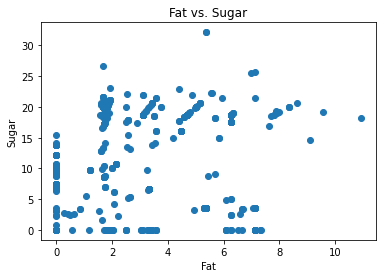

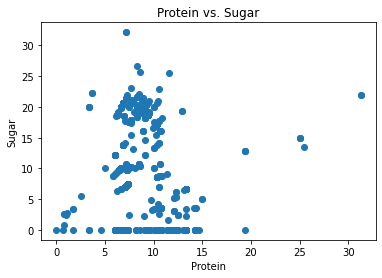

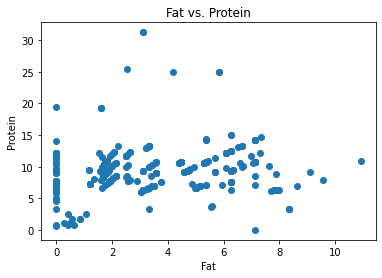

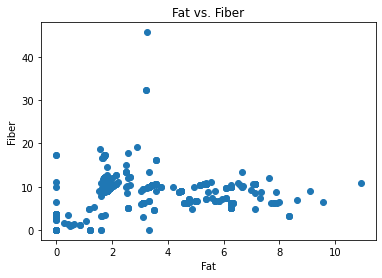

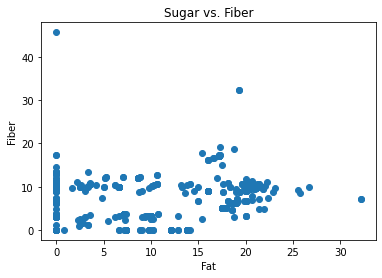

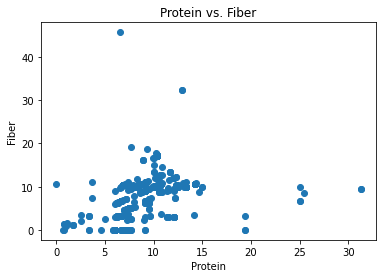

In [30]:
plt.scatter(Cereals['FAT'], Cereals['SUGAR'])
plt.title("Fat vs. Sugar")
plt.xlabel("Fat")
plt.ylabel("Sugar")
plt.show()

plt.scatter(Cereals['PROTEIN'], Cereals['SUGAR'])
plt.title("Protein vs. Sugar")
plt.xlabel("Protein")
plt.ylabel("Sugar")
plt.show()

plt.scatter(Cereals['FAT'], Cereals['PROTEIN'])
plt.title("Fat vs. Protein")
plt.xlabel("Fat")
plt.ylabel("Protein")
plt.show()

plt.scatter(Cereals['FAT'], Cereals['FIBER'])
plt.title("Fat vs. Fiber")
plt.xlabel("Fat")
plt.ylabel("Fiber")
plt.show()

plt.scatter(Cereals['SUGAR'], Cereals['FIBER'])
plt.title("Sugar vs. Fiber")
plt.xlabel("Fat")
plt.ylabel("Fiber")
plt.show()

plt.scatter(Cereals['PROTEIN'], Cereals['FIBER'])
plt.title("Protein vs. Fiber")
plt.xlabel("Protein")
plt.ylabel("Fiber")
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection ="3d")

ax.scatter( Cereals['FAT'], Cereals['CARB'],Cereals['PROTEIN'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

fig.suptitle('Product differentiation - 3D')
plt.show()

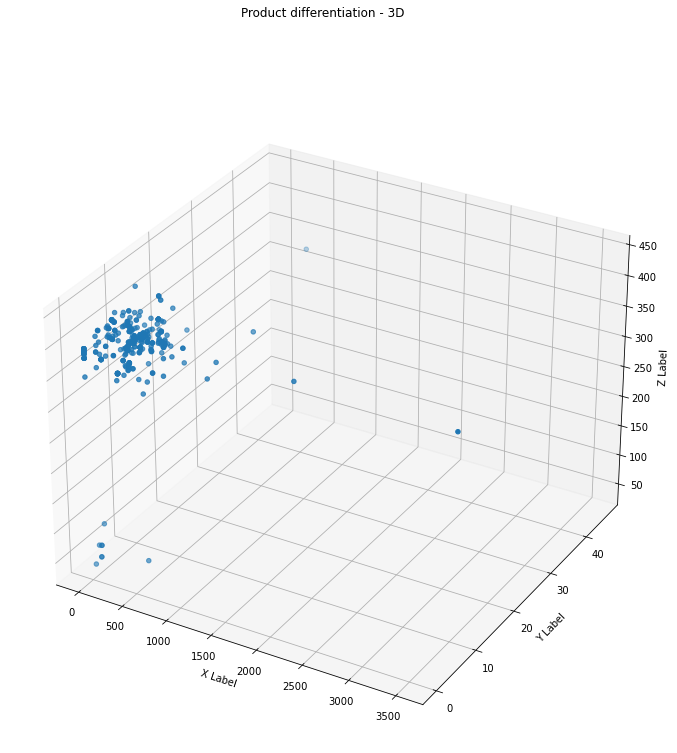

In [32]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection ="3d")

ax.scatter( Cereals['CALCIUM'], Cereals['FIBER'],Cereals['CALORIES'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

fig.suptitle('Product differentiation - 3D')
plt.show()

### 2.2 K-Means clustering
Using the K-means clustering technique analyze the degree of product differentiation. Based on descriptive statistics, data availability, and scatter plots, choose pairs of features (i.e., nutrition facts) on which you believe the sellers differentiate themselves. Quantify your answer. You should try different K parameters. Report the goodness of fit (total sum of errors). *Instead of different pairs of features you can focus on the same pair and compare different locations or different supermarkets.*

## 3 Conclusions
Summarize your findings and draw conclusions from them. What can you recommend to cereal producers on the market? Do you find this market to be saturated? Here, I leave it to you to analyze your findings as you see fit. Given all the effort you have put, This section should be as very important.